In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import itertools
import seaborn as sns
from sqlalchemy import create_engine

import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# 0.0 Initialize the Data

## 0.1 Import Table from SQL database on AWS

In [74]:
# create engine to connect my sql database

cnx = create_engine('postgresql://kaitlinpuryear@54.196.215.198:5432/kaitlinpuryear')

In [75]:
# create pandas dataframe from table in the sql database

df = pd.read_sql_query('''SELECT * FROM noshows3''',cnx)

In [76]:
df=df.drop(labels=["index"], axis=1)

In [77]:
df.head()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,text_sent,showed_up,woman,delta
0,62,False,True,False,False,False,False,True,True,0
1,56,False,False,False,False,False,False,True,False,0
2,62,False,False,False,False,False,False,True,True,0
3,8,False,False,False,False,False,False,True,True,0
4,56,False,True,True,False,False,False,True,True,0


In [79]:
# add more features
# (T/F) patient showing up for more than one problem

df['2+problems'] = (df['hypertension']+df['diabetes']+df['alcoholism']+df['handicap']>2)

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


## 0.2 Define y and X, and some feature engineering

In [80]:
df.head()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,text_sent,showed_up,woman,delta,2+problems
0,62,False,True,False,False,False,False,True,True,0,False
1,56,False,False,False,False,False,False,True,False,0,False
2,62,False,False,False,False,False,False,True,True,0,False
3,8,False,False,False,False,False,False,True,True,0,False
4,56,False,True,True,False,False,False,True,True,0,False


In [81]:
# define response vector

y0 = df["showed_up"]

In [82]:
# define feature matrix

X0 = df.drop(['showed_up'], axis=1)

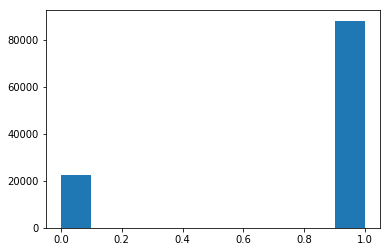

In [83]:
# Visual representation of unbalanced classes. ~4:1 ratio of true:false

plt.hist(y0);

# 1.0 Stratified Train Test Split

In [84]:
# create a stratified train/test split
# Note: classes are still imbalanced

x0train, x0test, y0train, y0test = train_test_split(X0, y0, test_size=0.4, random_state=40, stratify=y0)

In [85]:
# training set response imbalance

y0train.value_counts()

True     52925
False    13391
Name: showed_up, dtype: int64

## 1.1 Training Data: Upsampling the Minority

In [86]:
# training set response imbalance

train_minority = (y0train==False)
train_minority.value_counts()

False    52925
True     13391
Name: showed_up, dtype: int64

In [88]:
# combine x and y into one dataset to prepare for upsampling

x0train["Showed_up"]=y0train

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
# Separate majority (True) and minority (False) classes

train_majority = x0train[x0train.Showed_up==True]
train_minority = x0train[x0train.Showed_up==False]
 
# upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,        # sample without replacement
                                 n_samples=52925,     # to match majority class
                                 random_state=123)    # reproducible results
 
# Combine majority class with upsampled minority class
y_train_upsampled = pd.concat([train_minority_upsampled, train_majority])
 
# Display new class counts
y_train_upsampled.Showed_up.value_counts()

True     52925
False    52925
Name: Showed_up, dtype: int64

In [90]:
# reassign x and y (New and improved after upsampling!)

y1train = y_train_upsampled["Showed_up"]
x1train = y_train_upsampled.drop(['Showed_up'], axis=1)

In [91]:
# Confirm that all looks good and True/False are equal

y1train.value_counts()

True     52925
False    52925
Name: Showed_up, dtype: int64

## 1.2 Testing Data: Upsampling the Minority

In [92]:
# test set response imbalance

y0test.value_counts()

True     35283
False     8928
Name: showed_up, dtype: int64

In [93]:
# combine y and x into one dataframe to prepare for upsampling

x0test["Showed_up"]=y0test

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
# Separate majority (True) and minority (False) classes

test_majority = x0test[x0test.Showed_up==True]
test_minority = x0test[x0test.Showed_up==False]
 
# Upsample minority class
test_minority_upsampled = resample(train_minority, 
                                 replace=True,        # sample without replacement
                                 n_samples=35283,     # to match majority class
                                 random_state=123)    # reproducible results
 
# Combine minority class with downsampled majority class
y_test_upsampled = pd.concat([test_minority_upsampled, test_majority])
 
# Display new class counts
y_test_upsampled.Showed_up.value_counts()

True     35283
False    35283
Name: Showed_up, dtype: int64

In [95]:
# reassign xtest and ytest (New and improved balanced data!)

y1test = y_train_upsampled["Showed_up"]
x1test = y_train_upsampled.drop(['Showed_up'], axis=1)

In [96]:
# Make sure True/False is equal

y1test.value_counts()

True     52925
False    52925
Name: Showed_up, dtype: int64

# 2.0 Define Functions and Other Useful Tools

## 2.1 Normalize the dataframe because you will need that for knn

In [97]:
# Normalize only x

normalizer = preprocessing.Normalizer()
x1test_norm = normalizer.fit_transform(x1test)
x1train_norm = normalizer.fit_transform(x1train)

## 2.2 Define a Function that will draw Confusion Matrices

In [98]:
# define a function to draw beautiful confusion matrix!

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Reds):

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")


# 3.0 Fitting Different Models

## 3.1 K-Nearest Neighbors

In [23]:
# Gotta find the best k value. Iterate through a list and find the largest f1 score
'''
f1_knn = {}
for i in range(50):
    knn = KNeighborsClassifier(n_neighbors=(i+1))
    knn.fit(x1train, y1train)
    y_pred = knn.predict(x1test)
    f1_knn[i+1] = metrics.f1_score(y_pred, y1test)
    '''
# looks like k=30 is a good k value

'\nf1_knn = {}\nfor i in range(50):\n    knn = KNeighborsClassifier(n_neighbors=(i+1))\n    knn.fit(x1train, y1train)\n    y_pred = knn.predict(x1test)\n    f1_knn[i+1] = metrics.f1_score(y_pred, y1test)\n    '

In [24]:
# fit the model to the test set, using k=30

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(x1train_norm, y1train)
y_pred = knn.predict(x1test_norm)

In [25]:
# print a nice little scorecard for this model

print("Model accuracy: {:.2f}%".format(knn.score(x1train, y1train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y1test)))
print(metrics.classification_report(y1test, knn.predict(x1test_norm)))

Model accuracy: 70.36%
Model F1 Score: 0.66
             precision    recall  f1-score   support

      False       0.66      0.83      0.74     52925
       True       0.77      0.58      0.66     52925

avg / total       0.72      0.70      0.70    105850



AREA UNDER CURVE: 0.774129386131


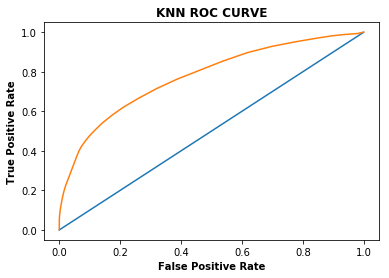

In [26]:
# Plot ROC Curve and print AUC

y_score=knn.predict_proba(x1test_norm)[:,1]

fpr, tpr,_ = roc_curve(y1test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot([0,1],[0,1]) # Plotting our Baseline
plt.plot(fpr,tpr)
plt.title('KNN ROC CURVE', fontweight='bold')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
print("AREA UNDER CURVE: "+str(roc_auc));

Model accuracy: 70.36%
[[43755  9170]
 [22206 30719]]


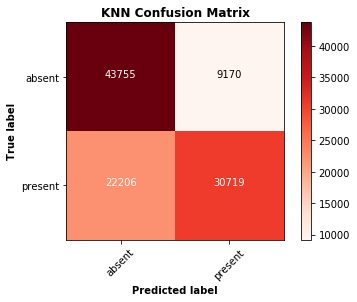

In [27]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.title("KNN Confusion Matrix", fontweight="bold")
plt.ylabel('True label', fontweight='bold')
plt.xlabel('Predicted label', fontweight='bold')

print("Model accuracy: {:.2f}%".format(knn.score(x1train, y1train)*100))
plot_confusion_matrix(metrics.confusion_matrix(y1test,y_pred), ['absent', 'present'])

## 3.2 Logistic Regression



In [28]:
# fit a logistic regression model, print the f1 score

logistic = LogisticRegression(penalty='l2', 
                              dual=True, 
                              tol=0.0001, 
                              C=200.0, 
                              fit_intercept=True, 
                              intercept_scaling=1, 
                              class_weight='balanced', 
                              random_state=135, 
                              solver='liblinear', 
                              max_iter=100, 
                              multi_class='ovr', 
                              verbose=0, warm_start=False, n_jobs=1)
logistic.fit(x1train,y1train)
y_pred = logistic.predict(x1test)

In [29]:
# Print a nice little score card for this model

print("Model accuracy: {:.2f}%".format(logistic.score(x1train, y1train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y1test)))
print(metrics.classification_report(y1test, logistic.predict(x1test_norm)))

Model accuracy: 53.11%
Model F1 Score: 0.16
             precision    recall  f1-score   support

      False       0.00      0.00      0.00     52925
       True       0.50      1.00      0.67     52925

avg / total       0.25      0.50      0.33    105850



AREA UNDER CURVE: 0.623370622995


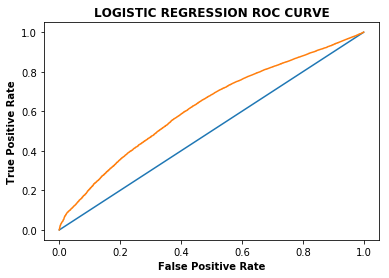

In [30]:
# Plot ROC Curve and print AUC

y_score=logistic.predict_proba(x1test)[:,1]

fpr, tpr,_ = roc_curve(y1test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.title("LOGISTIC REGRESSION ROC CURVE", fontweight="bold")
plt.xlabel('False Positive Rate', fontweight="bold")
plt.ylabel('True Positive Rate', fontweight='bold')
print("AREA UNDER CURVE: "+str(roc_auc));

[[51550  1375]
 [48262  4663]]


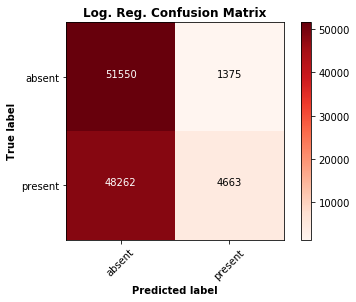

In [31]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.title("Log. Reg. Confusion Matrix", fontweight='bold')
plt.ylabel('True label', fontweight="bold")
plt.xlabel('Predicted label', fontweight='bold')

plot_confusion_matrix(metrics.confusion_matrix(y1test,y_pred), ['absent', 'present'])

## 3.3 Naive Bayes (Bernoulli)

In [32]:
# Fit a Naive Bayes (Bernoulli version) model and print the f1 score

bernoulli = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
bernoulli.fit(x1train, y1train)
y_pred = bernoulli.predict(x1test)

In [33]:
# Print a nice little score card for this model

print("Model accuracy: {:.2f}%".format(bernoulli.score(x1train, y1train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y1test)))
print(metrics.classification_report(y1test, bernoulli.predict(x1test_norm)))

Model accuracy: 66.67%
Model F1 Score: 0.57
             precision    recall  f1-score   support

      False       0.61      0.89      0.73     52925
       True       0.80      0.44      0.57     52925

avg / total       0.71      0.67      0.65    105850



AREA UNDER CURVE: 0.672537955936


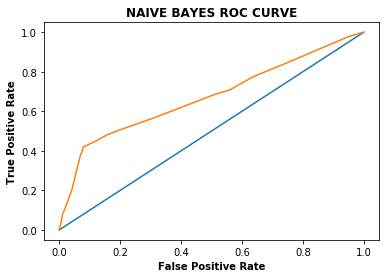

In [34]:
# Plot the ROC Curve and print AUC

y_score=bernoulli.predict_proba(x1test)[:,1]

fpr, tpr,_ = roc_curve(y1test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.title("NAIVE BAYES ROC CURVE", fontweight='bold')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
print("AREA UNDER CURVE: "+str(roc_auc));

[[47265  5660]
 [29621 23304]]


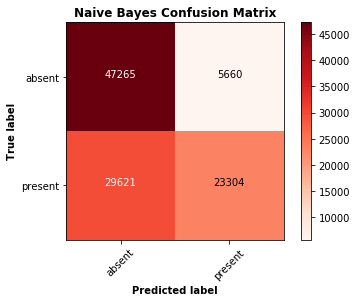

In [35]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.title("Naive Bayes Confusion Matrix", fontweight='bold')
plt.ylabel('True label', fontweight='bold')
plt.xlabel('Predicted label', fontweight='bold')

plot_confusion_matrix(metrics.confusion_matrix(y1test,y_pred), ['absent', 'present'])

## 3.4 Decision Trees

In [36]:
# determining max depth
'''
f1_df={}
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
for i in range(40):
    decisiontree = DecisionTreeClassifier(class_weight = 'balanced', max_depth=(i+30))
    decisiontree.fit(xtrain, ytrain)
    y_pred = decisiontree.predict(xtest)
    f1_df[i+30] = metrics.f1_score(y_pred, ytest)
    '''
# looks like max_depth=60 is the best

"\nf1_df={}\nxtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)\nfor i in range(40):\n    decisiontree = DecisionTreeClassifier(class_weight = 'balanced', max_depth=(i+30))\n    decisiontree.fit(xtrain, ytrain)\n    y_pred = decisiontree.predict(xtest)\n    f1_df[i+30] = metrics.f1_score(y_pred, ytest)\n    "

In [37]:
# Fit a Decision Tree model to the data, with max_depth=60

decisiontree = DecisionTreeClassifier(class_weight = 'balanced', max_depth=5)
decisiontree.fit(x1train, y1train)
y_pred = decisiontree.predict(x1test)

In [38]:
# Print a nice little score card for this model

print("Model accuracy: {:.2f}%".format(decisiontree.score(x1train, y1train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y1test)))
print(metrics.classification_report(y1test, decisiontree.predict(x1test)))

Model accuracy: 67.56%
Model F1 Score: 0.60
             precision    recall  f1-score   support

      False       0.63      0.87      0.73     52925
       True       0.78      0.49      0.60     52925

avg / total       0.71      0.68      0.66    105850



AREA UNDER CURVE: 0.727388861476


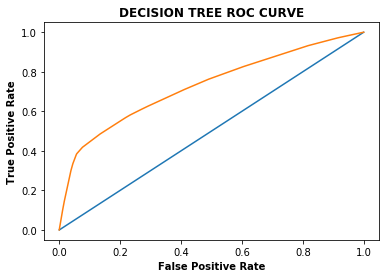

In [39]:
# Plot the ROC Curve and print AUC

y_score=decisiontree.predict_proba(x1test)[:,1]

fpr, tpr,_ = roc_curve(y1test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.title("DECISION TREE ROC CURVE", fontweight='bold')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
print("AREA UNDER CURVE: "+str(roc_auc));

[[45819  7106]
 [27230 25695]]


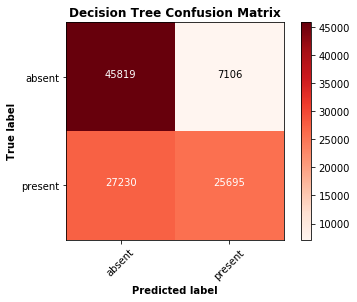

In [40]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.title("Decision Tree Confusion Matrix", fontweight='bold')
plt.ylabel('True label', fontweight='bold')
plt.xlabel('Predicted label', fontweight='bold')

plot_confusion_matrix(metrics.confusion_matrix(y1test,y_pred), ['absent', 'present'])

In [100]:
# visualize the tree!

dot_data = StringIO()
# "dt" is the decision tree classifier
# decisiontree.fit(x1train,y1train)
export_graphviz(decisiontree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = ['age', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'Handicap', 'Text_Sent',
                               'woman', 'delta'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


AttributeError: module 'pydotplus' has no attribute 'graph_from_dot_data'

## 3.5 Random Forest

In [142]:
parameters = {'max_depth': list(range(1,20)), 'n_estimators': list(range(1,100))}


In [104]:
randomforest = RandomForestClassifier(class_weight="balanced")
gridsearched=GridSearchCV(randomforest, parameters)
gridsearched.fit(x1train, y1train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4], 'n_estimators': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [143]:
# Fit a Random Forest Model to the dataset

randomforest = RandomForestClassifier(class_weight = 'balanced', max_depth=15, n_estimators=100)
randomforest.fit(x1train, y1train)
y_pred = randomforest.predict(x1test)

In [144]:
# Print a nice little score card for this model

print("Model accuracy: {:.2f}%".format(randomforest.score(x1train, y1train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y1test)))
print(metrics.classification_report(y1test, randomforest.predict(x1test_norm)))

Model accuracy: 76.23%
Model F1 Score: 0.73
             precision    recall  f1-score   support

      False       0.67      0.15      0.25     52925
       True       0.52      0.93      0.67     52925

avg / total       0.60      0.54      0.46    105850



AREA UNDER CURVE: 0.84462589189


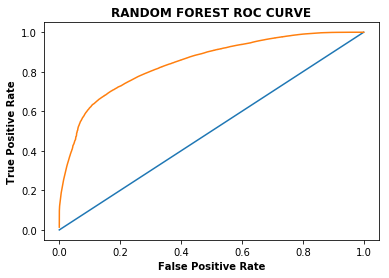

In [145]:
# Plot the ROC Curve and print the AUC

y_score=randomforest.predict_proba(x1test)[:,1]

fpr, tpr,_ = roc_curve(y1test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.title("RANDOM FOREST ROC CURVE", fontweight='bold')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
print("AREA UNDER CURVE: "+str(roc_auc));

[[47010  5915]
 [19241 33684]]


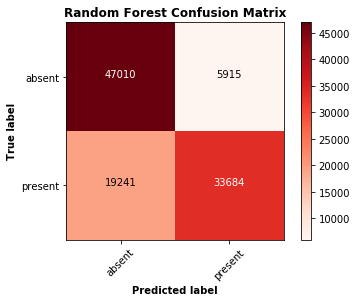

In [146]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.title("Random Forest Confusion Matrix", fontweight='bold')
plt.ylabel('True label', fontweight='bold')
plt.xlabel('Predicted label', fontweight='bold')

plot_confusion_matrix(metrics.confusion_matrix(y1test,y_pred), ['absent', 'present'])

# 4.0 Comparing Across Models

0.727388861476 AUC Decision Tree
0.84462589189 AUC Random Forest
0.77401285078 AUC K Nearest Neighbors
0.672537955936 AUC Naive Bayes (Bernoulli)
0.623370622995 AUC Logistic Regression


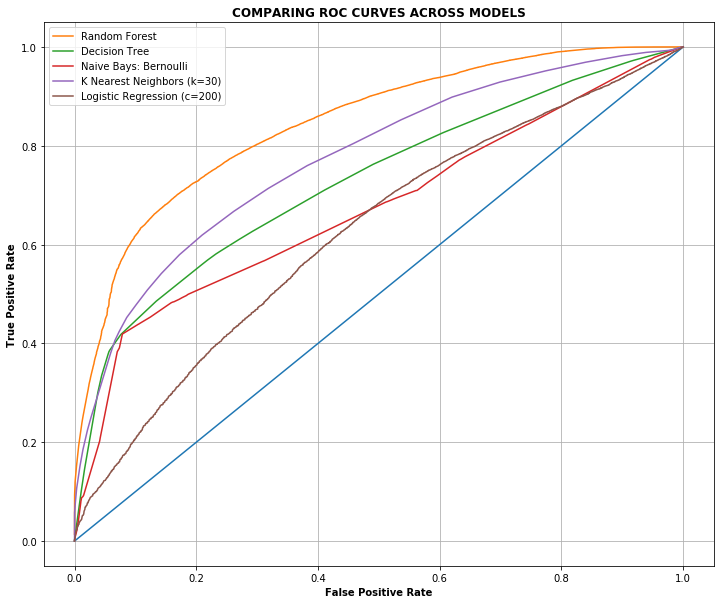

In [147]:
y_rf_score=randomforest.predict_proba(x1test)[:,1]
y_dt_score=decisiontree.predict_proba(x1test)[:,1]
y_nb_score=bernoulli.predict_proba(x1test)[:,1]
y_knn_score=knn.predict_proba(x1test)[:,1]
y_log_score=logistic.predict_proba(x1test)[:,1]

rf_fpr, rf_tpr,_ = roc_curve(y1test, y_rf_score)
dt_fpr, dt_tpr,_ = roc_curve(y1test, y_dt_score)
nb_fpr, nb_tpr,_ = roc_curve(y1test, y_nb_score)
knn_fpr, knn_tpr,_ = roc_curve(y1test, y_knn_score)
log_fpr, log_tpr,_ = roc_curve(y1test, y_log_score)

plt.figure(figsize=(12,10))
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(rf_fpr,rf_tpr, label='Random Forest')
plt.plot(dt_fpr,dt_tpr, label='Decision Tree')
plt.plot(nb_fpr,nb_tpr, label='Naive Bays: Bernoulli')
plt.plot(knn_fpr,knn_tpr, label='K Nearest Neighbors (k=30)')
plt.plot(log_fpr,log_tpr, label='Logistic Regression (c=200)')
plt.title("COMPARING ROC CURVES ACROSS MODELS", fontweight='bold')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.legend()
plt.grid(True)

print(str(metrics.auc(dt_fpr, dt_tpr))+" AUC Decision Tree")
print(str(metrics.auc(rf_fpr, rf_tpr))+" AUC Random Forest")
print(str(metrics.auc(knn_fpr, knn_tpr))+" AUC K Nearest Neighbors")
print(str(metrics.auc(nb_fpr, nb_tpr))+" AUC Naive Bayes (Bernoulli)")
print(str(metrics.auc(log_fpr, log_tpr))+" AUC Logistic Regression")
